In [1]:
import pandas as pd
import json
from sentence_transformers import SentenceTransformer
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from openai import OpenAI
from eval_veracity_prediction import print_evaluation_results

/home/venky/quantemp_reasoning/experiments/adaptive_decomposition/adaptive_decomp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("../openAI_apikey.json", "r") as fp:
    openai_api_key = json.load(fp)["openAI_api_key"]
client = OpenAI(api_key=openai_api_key)

#### Read and preprocess quantemp

In [3]:
with open("../data/quantemp/test_claims_quantemp.json", "r") as fp:
    data = json.load(fp)
data = pd.DataFrame(data)
data = data[["query_id", "claim", "taxonomy_label", "doc",  "label"]]

In [4]:
def generate_embeddings(data, embedding_model, with_taxonomy = False, with_evidence = False, use_openai = False,):
    embedded_list = []
    label_list = []
    for idx in tqdm(range(len(data))):
        sample = data.iloc[idx]
        if with_taxonomy == True and with_evidence == True: 
            sentence = f"""
                        [Claim]: {sample["claim"]}
                        [Taxonomy]: {sample["taxonomy_label"]}
                        [Evidence]: {sample["doc"]}
                        """
        elif with_taxonomy == True: 
            sentence = f"""
                        [Claim]: {sample["claim"]}
                        [Taxonomy]: {sample["taxonomy_label"]}
                        """
        elif with_evidence == True: 
            sentence = f"""
                        [Claim]: {sample["claim"]}
                        [Evidence]: {sample["doc"]}
                        """
        else:
            sentence = f"""
                        [Claim]: {sample["claim"]}
                        """
        sentence = sentence.replace("\n", " ")
        if use_openai == True: 
            embedded_claim = client.embeddings.create(input = [sentence], model="text-embedding-3-small", dimensions = 512 ).data[0].embedding
        elif use_openai == False:  
            embedded_claim = embedding_model.encode(sentence)
        label_list.append(sample["label"])
        embedded_list.append(np.array(embedded_claim))
    
    return embedded_list, label_list

In [5]:
embedding_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

In [6]:
data.head()

,query_id,claim,taxonomy_label,doc,label
0,0,"""The non-partisan Congressional Budget Office ...",statistical,Republican U.S House candidate Roger Williams ...,Conflicting
1,1,"""More than 50 percent of immigrants from (El S...",statistical,The crisis at the border brought on by thousan...,True
2,2,UK government banned Covid vaccine for childre...,temporal,"""BREAKING: Children in the UK aged 5-11 will n...",False
3,3,"""[In 2014-2015] coverage for the rotavirus vac...",statistical,In its annual performance plan the Free State ...,False
4,4,"In September 2021, the U.K. government announc...",temporal,"In September 2021, several news outlets and we...",True


In [7]:
# embedded_list, label_list = generate_embeddings(data, embedding_model, with_taxonomy=True, with_evidence=True, use_openai=True)
embedded_list, label_list = np.load("../data/openAI_embedding/small_evidence_taxonomy.npy"), np.load("../data/openAI_embedding/label_list.npy")
embedded_list = np.array(embedded_list)
print(f"Embedded list shape: {embedded_list.shape}")
tsne = TSNE(n_components=2, random_state=42)
pca = PCA(n_components=2, random_state=42)
tnse_embeddings = tsne.fit_transform(embedded_list)
pca_embeddings = pca.fit_transform(embedded_list)

Embedded list shape: (2495, 512)


In [8]:
# np.save("../data/openAI_embedding/small_evidence_taxonomy.npy", embedded_list)
# np.save("../data/openAI_embedding/label_list.npy", label_list)

In [10]:
def visualize_results(label_list, reduced_embeddings, embedding_type = "t-SNE"):

    class_names = ["True", "False", "Conflicting"]  # Unique class names in the same order

    # Define a color mapping for each class
    color_mapping = {"True": "green", "False": "red", "Conflicting": "blue"}

    # Create the plot
    plt.figure(figsize=(8, 6))

    # Plot each class with its respective color
    for class_name in class_names:
        indices = [i for i, label in enumerate(label_list) if label == class_name]
        plt.scatter(
            [reduced_embeddings[i, 0] for i in indices], 
            [reduced_embeddings[i, 1] for i in indices], 
            label=class_name,
            color=color_mapping[class_name]
        )

    # Add title and labels
    plt.title(f"Sentence Embeddings Visualized Using {embedding_type}")
    plt.xlabel(f"{embedding_type} Dimension 1")
    plt.ylabel(f"{embedding_type} Dimension 2")
    plt.legend()
    plt.grid(True)

#### Visualize the TSNE results

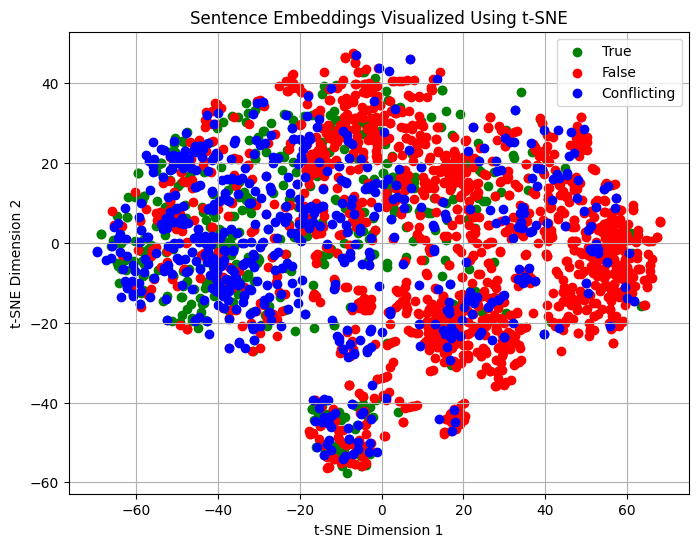

In [11]:
visualize_results(label_list, tnse_embeddings)

#### Try it with PCA algorithm

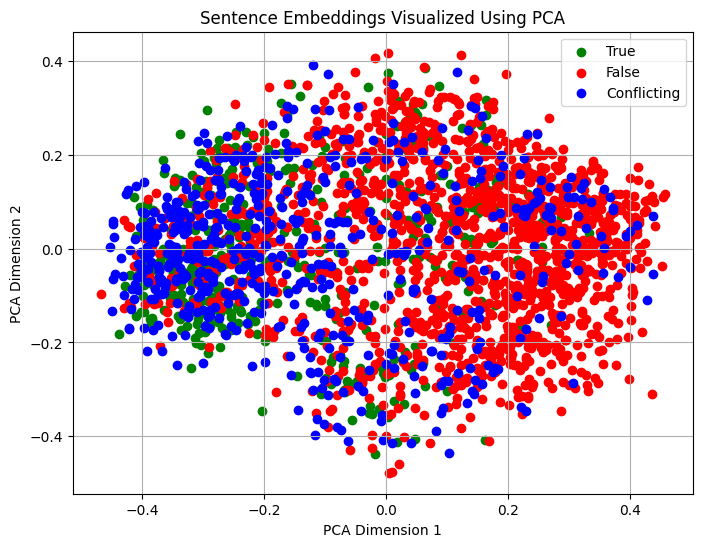

In [12]:
visualize_results(label_list, pca_embeddings, embedding_type="PCA")

#### Try training a classifier on top of them without dimensionality reduction

In [13]:
X, y = embedded_list, np.array(label_list)
# enc = OneHotEncoder(sparse_output = False)
# y_transformed = enc.fit_transform(y.reshape(y.shape[0], 1))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(embedded_list, y, test_size=0.2)
print(f"Shape of X_train, X_test, y_train, and y_test are: {X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")

Shape of X_train, X_test, y_train, and y_test are: (1996, 512), (499, 512), (1996,), (499,)


In [16]:
classfier = RandomForestClassifier()
classfier.fit(X_train, y_train)
y_pred = classfier.predict(X_test)
print_evaluation_results(y_pred, y_test)

              precision    recall  f1-score   support

       false     0.6961    0.9273    0.7953       289
        true     0.4783    0.1134    0.1833        97
 conflicting     0.4176    0.3363    0.3725       113

    accuracy                         0.6353       499
   macro avg     0.5306    0.4590    0.4504       499
weighted avg     0.5907    0.6353    0.5806       499

[[268   2  19]
 [ 52  11  34]
 [ 65  10  38]]



In [20]:
classfier = XGBClassifier()
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
classfier.fit(X_train, y_train_encoded)
y_pred = classfier.predict(X_test)
y_pred_inv = le.inverse_transform(y_pred)
print_evaluation_results(y_pred_inv, y_test)

              precision    recall  f1-score   support

       false     0.7723    0.8685    0.8176       289
        true     0.5455    0.3711    0.4417        97
 conflicting     0.4537    0.4336    0.4434       113

    accuracy                         0.6733       499
   macro avg     0.5905    0.5578    0.5676       499
weighted avg     0.6561    0.6733    0.6598       499

[[251  13  25]
 [ 27  36  34]
 [ 47  17  49]]

